## Part 1: check if the NN converges for a smaller set of training data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop

import time
import math

In [2]:
fname = 'DATA/sequences16.csv'
sx, sy = np.loadtxt(fname,
                    delimiter = ",",
                    usecols=(0,1), 
                    unpack=True, dtype=str)

N=len(sy)
print(N)

Ls=len(sx[0])
print(Ls)

print(sx[0],sy[0])

perc_train=0.8
N_train=int(N*perc_train)
N_test=N-N_train

print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_test}')

3000
16
AAGGTCTGCCGGCCGA 1

data: 3000
train: 2400
test: 600


In this case the number of training samples is reduced to 2400 wrt 8000 of the previous notebook, moreover here we have sequences of 16 characters instead of 12.
Characters have to be encoded into a sequence of 4 bits through a dictionary telling the position of '1' into the same ensamble of bits for each character.

In [3]:
#hot encoding to associate each character to a sequence of 0 and 1
Q = ["A","C","G","T"]
Nc=4
onehc={Q[i]:i for i in range(Nc)} #one hot encoding
print(onehc)

{'A': 0, 'C': 1, 'G': 2, 'T': 3}


### Data conversion


We will have arrays of 4 times the number of characters in a sequence of zeros and ones:

In [4]:
y = sy.astype(int)

L = Ls*Nc
print(L) #length of input layer

x = np.zeros((N,L)) #every row is an input
print(x[0])

for n in range(N): #for each sample
    for i in range(Ls): #for each character
        x[n][i*4 + onehc[sx[n][i]]] = 1
        
print(sx[0])
print(x[0])  

64
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AAGGTCTGCCGGCCGA
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


### Split Train/Test-Validation

In [5]:
(x_train,y_train) = (x[:N_train],y[:N_train]) #TRAINING SET
(x_test,y_test)  = (x[N_train:],y[N_train:]) #TEST SET

print("Fraction of data=1 in the training:",y_train.sum()/N_train)
print("Fraction of data=1 in the test:",y_test.sum()/N_test)
#They are very similar

Fraction of data=1 in the training: 0.24333333333333335
Fraction of data=1 in the test: 0.25833333333333336


### Definition of model in keras

In [6]:
np.random.seed(123)

model = Sequential()

#I choose narrower dimensions of layers in my model (that's my choice)
#also activation is my choice
model.add(Dense(L,input_shape=(L,),activation="relu")) #set input layer of shape (1,0)
model.add(Dense(L/2,activation="relu"))
model.add(Dense(L/4,activation="relu"))
model.add(Dropout(0.2)) #drop non active nodes in the last layer(?)

#now I change the activation function because I want a prediciton as a probability of being 1
model.add(Dense(1,activation="sigmoid")) #OUTPUT


print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


### Optimization

We first choose arbitrarily the architecture of the NN. The optimizer is Nesterov version of SGD algorithm and the loss function is the binary cross entropy. Then we select the batch size and the number of epochs letting the model shuffle the data for each iteration to prevent biases due to the order of samples.  

In [7]:
opt1 = SGD(learning_rate=0.1,
           momentum=0.9,
           nesterov=True) 
model.compile(loss="binary_crossentropy", 
             optimizer=opt1, 
             metrics=['accuracy']) 
fit = model.fit(x_train, y_train, 
               epochs=30, batch_size=50,
               validation_data=(x_test,y_test),
                shuffle=True)

Epoch 1/30
48/48 [==============================] - 1s 20ms/step - loss: 0.5711 - accuracy: 0.7415 - val_loss: 0.5237 - val_accuracy: 0.7417
Epoch 2/30
48/48 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.7605 - val_loss: 0.4983 - val_accuracy: 0.7567
Epoch 3/30
48/48 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.7749 - val_loss: 0.4820 - val_accuracy: 0.7650
Epoch 4/30
48/48 [==============================] - 0s 1ms/step - loss: 0.4112 - accuracy: 0.8048 - val_loss: 0.5101 - val_accuracy: 0.7317
Epoch 5/30
48/48 [==============================] - 0s 1ms/step - loss: 0.3480 - accuracy: 0.8449 - val_loss: 0.4976 - val_accuracy: 0.7517
Epoch 6/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.8671 - val_loss: 0.4629 - val_accuracy: 0.7817
Epoch 7/30
48/48 [==============================] - 0s 1ms/step - loss: 0.2483 - accuracy: 0.8964 - val_loss: 0.4939 - val_accuracy: 0.7750
Epoch 8/30
48/48 [=

19/19 [==============================] - 0s 665us/step - loss: 1.2911 - accuracy: 0.8200

Test loss: 1.2910586595535278
Test accuracy: 0.8199999928474426


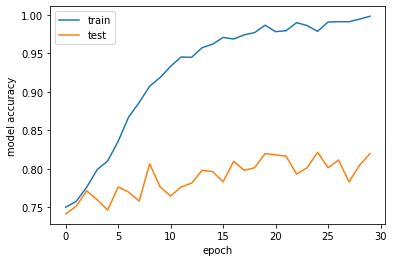

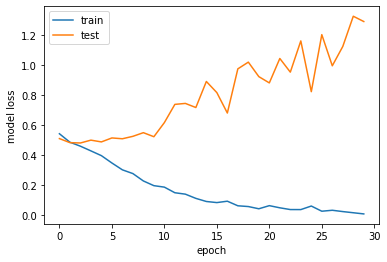

In [14]:
#Plot the results

score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Because of the decreased number of samples in the training samples the NN doesn't manage to converge. We see infact that not only the test set increases during each iteration but also that the difference between the training test and the test one is large meaning overfitting of the model. It's probably due to the little number of samples for training leading the NN to adapt only on that non representative set and not being able to generalize for "real" samples.

## Part 2: data augmentation

To enlarge the training set, since we have sequences of nucleotides, we can shift one nucleotide to the left and all the others following. We therefore keep the meaning of the sequence but incrementing the number of training samples. What we want to discover is a particoular key giving the label one to certain sequences instead of others. We don't know the law that generated the data so when shifting one character there will be one shift that will corrupt the underlying law assigning the labels since it is based on the order of two or more near letters. One of the 16-1 possible shifts will certainly cause the above situation. 

In [8]:
new_x_train = []
new_y_train = []
# creo due liste che aggiorno dentro il ciclo for attraverso 15 shift di ogni sample degli N totali 
x_train_reshape = x_train.reshape(x_train.shape[0], int(x_train.shape[1]/4), 4)
# per evitare di shiftare ogni volta un bit di quattro posizioni faccio il reshape dell'array di elementi nel sample in modo da avere un array di sequenze di quattro bits che saranno le righe del nuovo vettore

for j in range(x_train_reshape.shape[0]):
    for i in range(x_train_reshape[j].shape[0]):
        new_x_train.append(np.concatenate((x_train_reshape[j][i:],x_train_reshape[j][:i])))
        new_y_train.append(y_train[j])

new_x_train = np.array(new_x_train).reshape(x_train.shape[0]*16, x_train.shape[1])
new_y_train = np.array(new_y_train)

In [9]:
fit_new = model.fit(new_x_train, new_y_train, 
                    epochs=30, batch_size=50,
                    validation_data=(x_test,y_test),
                    shuffle=True)

Epoch 1/30
768/768 [==============================] - 0s 534us/step - loss: 0.4217 - accuracy: 0.8150 - val_loss: 0.3521 - val_accuracy: 0.8467
Epoch 2/30
768/768 [==============================] - 0s 496us/step - loss: 0.3440 - accuracy: 0.8560 - val_loss: 0.3296 - val_accuracy: 0.8600
Epoch 3/30
768/768 [==============================] - 0s 567us/step - loss: 0.3122 - accuracy: 0.8769 - val_loss: 0.3124 - val_accuracy: 0.8767
Epoch 4/30
768/768 [==============================] - 0s 550us/step - loss: 0.2846 - accuracy: 0.8928 - val_loss: 0.2669 - val_accuracy: 0.8917
Epoch 5/30
768/768 [==============================] - 0s 541us/step - loss: 0.2663 - accuracy: 0.9022 - val_loss: 0.2582 - val_accuracy: 0.8983
Epoch 6/30
768/768 [==============================] - 0s 580us/step - loss: 0.2525 - accuracy: 0.9112 - val_loss: 0.2359 - val_accuracy: 0.9083
Epoch 7/30
768/768 [==============================] - 0s 543us/step - loss: 0.2400 - accuracy: 0.9155 - val_loss: 0.2293 - val_accuracy:

19/19 [==============================] - 0s 665us/step - loss: 0.1515 - accuracy: 0.9483

Test loss: 0.15148226916790009
Test accuracy: 0.9483333230018616


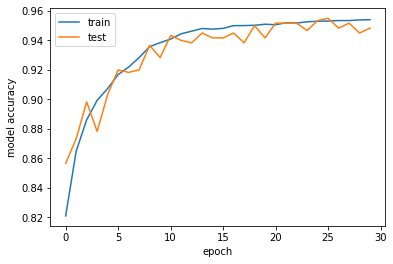

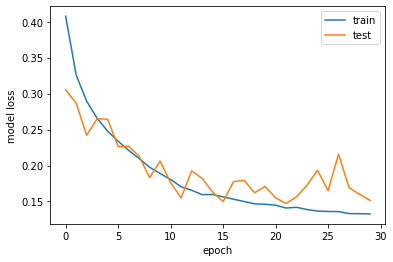

In [17]:
#Plot the results

score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# look into training history

# summarize history for accuracy
plt.plot(fit_new.history['accuracy'])
plt.plot(fit_new.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit_new.history['loss'])
plt.plot(fit_new.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

We can see that despite the corruption of a certain amount of data loosing their correct label and key, data augmentation led the model to achieve a better test error and to avoid overfitting

## Part 3 : gridsearch in NN hyperaparameters

We decide now to gridsearch for the optimal set of hyperparameters of our NN including the architecture, dropout probability, activation functions and backpropagation optimizer algorithm.

In [10]:
def compile_model(optimizer="adam",activation="relu",dropout_rate=0.2, learning_rate=0.1, momentum=0.9):
    # create the mode
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation=activation)) 
    model.add(Dense(L/2,activation=activation))
    model.add(Dense(L/4,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid")) 
    # compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [19]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                                   epochs=10, 
                                   batch_size=50, 
                                   verbose=1)

# list of allowed optional arguments for the optimizer, see compile_model()
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD','RMSprop', 'Adam']#,'Adamax'] #opt1 = SGD(learning_rate=0.1, momentum=0.9, nesterov=True) 
activation = ["relu","elu","sigmoid"]
dropout_rate = [0.2,0.8]
learning_rate = [0.001, 0.01]
momentum = [0.4, 0.9]
# define parameter dictionary
param_grid = dict(optimizer=optimizer,activation=activation,dropout_rate=dropout_rate,learning_rate=learning_rate, momentum=momentum)
#dict(learning_rate=learning_rate,momentum=momentum) 
#dict(optimizer=optimizer,activation=activation,dropout_rate=dropout_rate,learning_rate=learning_rate, momentum=momentum)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(new_x_train,new_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

8/10
576/576 [==============================] - 0s 414us/step - loss: 0.5582 - accuracy: 0.7552
Epoch 9/10
576/576 [==============================] - 0s 429us/step - loss: 0.5524 - accuracy: 0.7596
Epoch 10/10
192/192 [==============================] - 0s 362us/step - loss: 0.5644 - accuracy: 0.7483
Epoch 1/10
576/576 [==============================] - 1s 452us/step - loss: 0.6411 - accuracy: 0.6894
Epoch 2/10
576/576 [==============================] - 0s 455us/step - loss: 0.5642 - accuracy: 0.7518
Epoch 3/10
576/576 [==============================] - 0s 450us/step - loss: 0.5351 - accuracy: 0.7522
Epoch 4/10
576/576 [==============================] - 0s 456us/step - loss: 0.5271 - accuracy: 0.7533
Epoch 5/10
576/576 [==============================] - 0s 453us/step - loss: 0.5275 - accuracy: 0.7503
Epoch 6/10
576/576 [==============================] - 0s 452us/step - loss: 0.5187 - accuracy: 0.7559
Epoch 7/10
576/576 [==============================] - 0s 467us/step - loss: 0.5178 - ac

In [20]:
grid_result.score(x_test,y_test)

12/12 [==============================] - 0s 453us/step - loss: 0.2884 - accuracy: 0.8800


0.8799999952316284

In [18]:
# act = grid_result.best_params_["activation"]
# drop = grid_result.best_params_["dropout_rate"]
# opt = grid_result.best_params_["optimizer"]
# learn = grid_result.best_params_["learning_rate"]
# mom = grid_result.best_params_["momentum"]

best_model = compile_model(activation='relu',dropout_rate=0.2,optimizer='Adam',learning_rate=0.001,momentum=0.9)
# quando compilo il modello lo ridefinisco completamente quindi posso anche allenarlo per i dati new_train e poi compilarlo nuovamente nella parte 4 per azzerare i pesi ottenuti qui e allenarlo invece con i samples rescaled new_train_0

    #learning_rate=learn,momentum=mom)
#compile_model(activation=act,dropout_rate=drop,optimizer=opt,learning_rate=learn,momentum=mom)
    #learning_rate=learn,momentum=mom)
    #activation=act,dropout_rate=drop,optimizer=opt,learning_rate=learn,momentum=mom)
fit_best = best_model.fit(new_x_train, new_y_train, 
                          epochs=30, batch_size=50,
                          validation_data=(x_test,y_test),
                          shuffle=True)

Epoch 1/30
768/768 [==============================] - 1s 906us/step - loss: 0.5250 - accuracy: 0.7587 - val_loss: 0.4564 - val_accuracy: 0.7800
Epoch 2/30
768/768 [==============================] - 1s 682us/step - loss: 0.4333 - accuracy: 0.7969 - val_loss: 0.3651 - val_accuracy: 0.8333
Epoch 3/30
768/768 [==============================] - 0s 598us/step - loss: 0.3501 - accuracy: 0.8485 - val_loss: 0.3299 - val_accuracy: 0.8517
Epoch 4/30
768/768 [==============================] - 0s 589us/step - loss: 0.2989 - accuracy: 0.8782 - val_loss: 0.3016 - val_accuracy: 0.8533
Epoch 5/30
768/768 [==============================] - 0s 588us/step - loss: 0.2708 - accuracy: 0.8935 - val_loss: 0.2675 - val_accuracy: 0.8983
Epoch 6/30
768/768 [==============================] - 0s 564us/step - loss: 0.2643 - accuracy: 0.8966 - val_loss: 0.2623 - val_accuracy: 0.9083
Epoch 7/30
768/768 [==============================] - 0s 644us/step - loss: 0.2449 - accuracy: 0.9094 - val_loss: 0.2674 - val_accuracy:

19/19 [==============================] - 0s 609us/step - loss: 0.2798 - accuracy: 0.9000

Test loss: 0.27982354164123535
Test accuracy: 0.8999999761581421


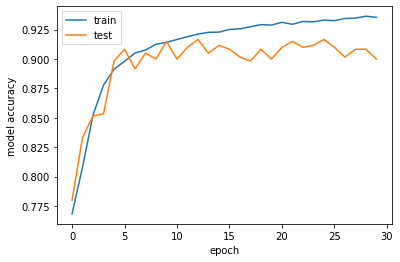

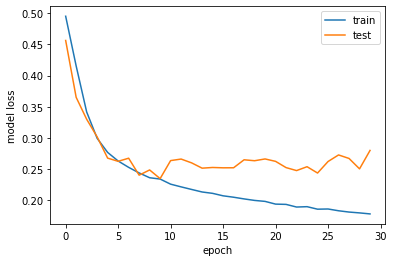

NameError: name 'score' is not defined

In [19]:
#Plot the results

score_best = best_model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score_best[0])
print('Test accuracy:', score_best[1])
# look into training history

# summarize history for accuracy
plt.plot(fit_best.history['accuracy'])
plt.plot(fit_best.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit_best.history['loss'])
plt.plot(fit_best.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# look into training history

# summarize history for accuracy
plt.plot(fit_new.history['accuracy'])
plt.plot(fit_new.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit_new.history['loss'])
plt.plot(fit_new.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

To save the just trained NN we can import the pack "model_to_json" from keras and write into a json file the architecture of the neural network:

In [24]:
from keras.models import model_from_json

# serialize model to JSON
model_json = best_model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# save weights to HDF5
best_model.save_weights("model.h5")
print("Model saved")

Model saved


In [25]:
# to retrieve the model we can just write the following instructions  
json_file = open('model.json', 'r')
saved_model = json_file.read()
# close the file as good practice
json_file.close()
model_from_json = model_from_json(saved_model)
# load weights into new model
model_from_json.load_weights("model.h5")
print("Model loaded")

Model loaded


## Part 4 : rescaling data to average zero

In [16]:
x_train_0 = new_x_train - 0.5 # per traslare i samples a media 1/2 a samples aventi media zero
y_train_0 = new_y_train
x_test_0 = x_test - 0.5
y_test_0 = y_test

fit_best_0 = best_model.fit(x_train_0, y_train_0, 
                          epochs=30, batch_size=50,
                          validation_data=(x_test_0,y_test_0),
                          shuffle=True)

Epoch 1/30
768/768 [==============================] - 1s 658us/step - loss: 0.5222 - accuracy: 0.7539 - val_loss: 0.4452 - val_accuracy: 0.8000
Epoch 2/30
768/768 [==============================] - 0s 552us/step - loss: 0.4177 - accuracy: 0.8096 - val_loss: 0.3821 - val_accuracy: 0.8367
Epoch 3/30
768/768 [==============================] - 0s 582us/step - loss: 0.3304 - accuracy: 0.8590 - val_loss: 0.3124 - val_accuracy: 0.8650
Epoch 4/30
768/768 [==============================] - 0s 577us/step - loss: 0.2881 - accuracy: 0.8844 - val_loss: 0.3196 - val_accuracy: 0.8583
Epoch 5/30
768/768 [==============================] - 0s 588us/step - loss: 0.2635 - accuracy: 0.8984 - val_loss: 0.2781 - val_accuracy: 0.9000
Epoch 6/30
768/768 [==============================] - 0s 577us/step - loss: 0.2545 - accuracy: 0.9054 - val_loss: 0.2780 - val_accuracy: 0.8917
Epoch 7/30
768/768 [==============================] - 0s 581us/step - loss: 0.2477 - accuracy: 0.9065 - val_loss: 0.2930 - val_accuracy:

19/19 [==============================] - 0s 665us/step - loss: 0.2947 - accuracy: 0.9017

Test loss: 0.29467055201530457
Test accuracy: 0.9016666412353516


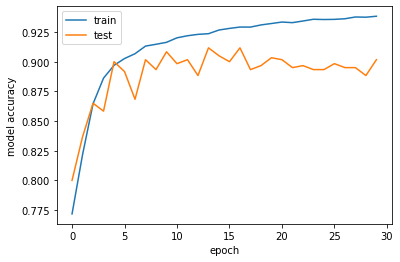

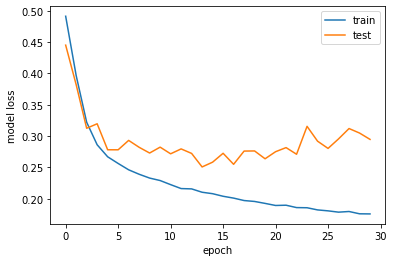

In [17]:
#Plot the results

score_best_0 = best_model.evaluate(x_test_0, y_test_0, verbose=1)

# print performance
print()
print('Test loss:', score_best_0[0])
print('Test accuracy:', score_best_0[1])
# look into training history

# summarize history for accuracy
plt.plot(fit_best_0.history['accuracy'])
plt.plot(fit_best_0.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit_best_0.history['loss'])
plt.plot(fit_best_0.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Attenzione 

Considerazione di Mattia: quando alleno il modello devo stare attento se già prima esso è stato allenato su un training set differente. Il metodo fit() prosegue l'update dei pesi da dove è stato interrotto quindi per allenare un modello da capo è necessario ricompilarlo!